<a href="https://colab.research.google.com/github/lambertae/controlnet-demosaicing/blob/master/6_8301_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 130.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 130.4 MB/s eta 0:00:00


In [3]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.9 MB/s eta 0:00:00


In [4]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import efficientnet
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

## Load Dataset
see https://colab.research.google.com/drive/1I5M1yvh9FheR8HReuiadQ1BhjpaxtGUs?usp=sharing#scrollTo=bxRwCfMYjyZw

This module yields `train_dataset` and `valid_dataset`.

In [5]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [6]:
# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 1
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())
            
            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue
                
            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]
        
        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]
                
        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [8]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomContrast(0.3),  
])

In [9]:
def decode_and_resize(img_path, size=IMAGE_SIZE):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    return img


def read_train_image(img_path, size=IMAGE_SIZE):
    img = decode_and_resize(img_path)
    img = image_augmentation(tf.expand_dims(img, 0))[0]
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def read_valid_image(img_path, size=IMAGE_SIZE):
    img = decode_and_resize(img_path)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def make_dataset(images, captions, split="train"):
    if split == "train":
        img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
            read_train_image, num_parallel_calls=AUTOTUNE)
    else:
        img_dataset = tf.data.Dataset.from_tensor_slices(images).map(
            read_valid_image, num_parallel_calls=AUTOTUNE)
    
    cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(
        vectorization, num_parallel_calls=AUTOTUNE)
    
    dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
    dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)
    return dataset

In [10]:
# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(
    list(train_data.keys()),
    list(train_data.values()),
    split="train"
    )

valid_dataset = make_dataset(
    list(valid_data.keys()),
    list(valid_data.values()),
     split="valid"
     )

### Visualize datasets

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def row_to_text(row):
    """
    Convert vectorized captions 
    (5 of them in a image-caption pair in the dataset) 
    back to text.
    """
    vocab = vectorization.get_vocabulary()
    index_to_word = dict(enumerate(vocab))
    return ' '.join([index_to_word[index] for index in row if index not in (0, 3, 4)])

def visualize_orginal_image(dataset):
    # Get the image and vectorized caption at the specified index
    image, vectorized_caption = next(iter(train_dataset.unbatch().take(1)))
    image = image.numpy().clip(0, 255).astype(np.uint8)

    # Convert the vectorized caption back to text
    captions = [row_to_text(row) for row in vectorized_caption.numpy()]

    # Display the image and the caption
    # print(captions)
    plt.title(max(captions, key=len))
    plt.imshow(image)
    # plt.title(captions)
    plt.axis('off')
    plt.show()

def center_crop(img):
    h, w, c = img.shape
    if h > w:
        img = img[(h-w)//2:(h-w)//2+w, :, :]
    else:
        img = img[:, (w-h)//2:(w-h)//2+h, :]
    return img

def get_pixelated_image_and_caption(dataset):
    image, vectorized_caption = next(iter(train_dataset.unbatch().take(1)))
    image = image.numpy().clip(0, 255).astype(np.uint8)
    captions = [row_to_text(row) for row in vectorized_caption.numpy()]

    # Center crop the image
    p_image = center_crop(image)

    # Resize the image to (256, 256) if it's not already
    if p_image.shape[0] != 256 or p_image.shape[1] != 256:
        p_image = cv2.resize(p_image, (256, 256), interpolation=cv2.INTER_LINEAR)

    # Pixelate the image by resizing down and then back up
    p_image = cv2.resize(p_image, (64, 64), interpolation=cv2.INTER_NEAREST)
    p_image = cv2.resize(p_image, (256, 256), interpolation=cv2.INTER_NEAREST)

    return image, p_image, max(captions, key=len)

def visualize_pixelated_image(dataset):
    # Get the pixelated image and caption
    _, pixelated_image, caption = get_pixelated_image_and_caption(dataset)

    # Create a new figure
    plt.figure(figsize=(5, 5))

    # Display the pixelated image
    plt.imshow(pixelated_image)

    # Set the title of the image as the caption
    plt.title(caption)

    # Remove the axes
    plt.axis('off')

    # Show the plot
    plt.show()


def visualize_both_images(dataset):
    # Get the original and pixelated image and caption
    image, p_image, caption = get_pixelated_image_and_caption(dataset)

    # Create a new figure with 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axs[0].imshow(image)
    axs[0].set_title('Original Image')

    # Display the pixelated image
    axs[1].imshow(p_image)
    axs[1].set_title('Pixelated Image')

    # Set the main title as the caption
    fig.suptitle(caption)

    # Remove the axes
    for ax in axs:
        ax.axis('off')

    # Show the plot
    plt.show()

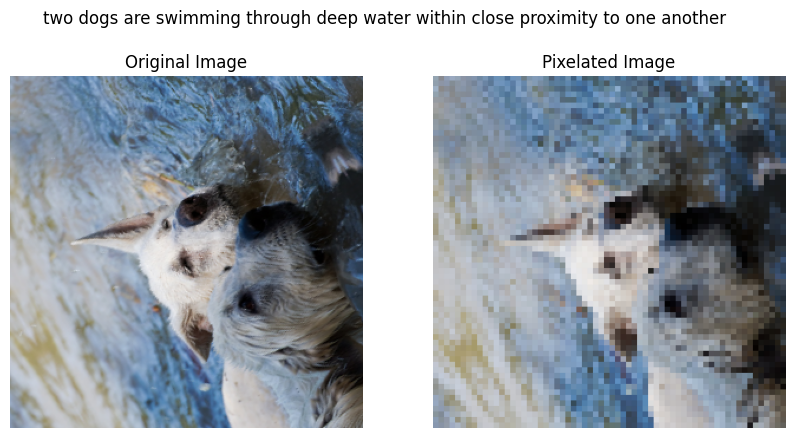

In [27]:
visualize_both_images(valid_dataset)

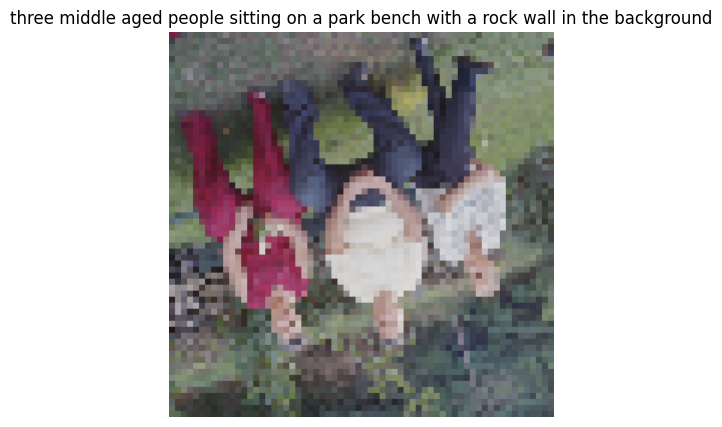

In [24]:
visualize_pixelated_image(valid_dataset)

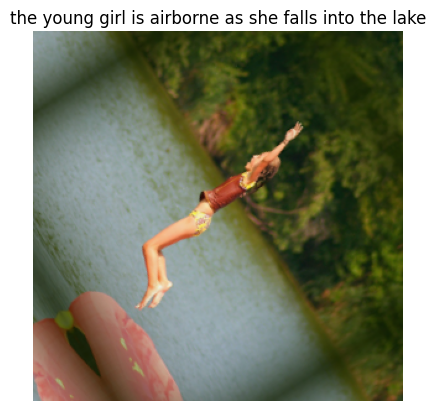

In [29]:
# Visualize the datapoint at index 10 in the training dataset
visualize_orginal_image(valid_dataset)

## Train ControlNet

In [4]:
# https://github.com/lambertae/controlnet-demosaicing/blob/master/train_controlnet.py
# model: https://huggingface.co/Goodeat/controlnet-demosaicing

## Evaluation


In [15]:
from diffusers import DiffusionPipeline
import torch


pipeline = DiffusionPipeline.from_pretrained("Goodeat/controlnet-demosaicing", torch_dtype=torch.float16,)
# pipeline.enable_xformers_memory_efficient_attention()
# pipeline.enable_model_cpu_offload()
# pipeline = pipeline.cuda()

diffusion_pytorch_model.safetensors not found


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

The config attributes {'global_pool_conditions': False} were passed to AutoencoderKL, but are not expected and will be ignored. Please verify your config.json configuration file.


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:947 in             │
│ from_pretrained                                                                                  │
│                                                                                                  │
│    944 │   │   │   │   │   loaded_sub_model = load_method(os.path.join(cached_folder, name), **  │
│    945 │   │   │   │   else:                                                                     │
│    946 │   │   │   │   │   # else load from the root directory                                   │
│ ❱  947 │   │   │   │   │   loaded_sub_model = load_method(cached_folder, **loading_kwargs)       │
│    948 │   │   │                                                                                 │
│    949 │   │   │   init_kwargs[name] = loaded_sub_model  # UNet(...), # DiffusionSchedule(...)   │
│    950                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/models/modeling_utils.py:558 in                │
│ from_pretrained                                                                                  │
│                                                                                                  │
│   555 │   │   │   │   │   │   device_map=device_map,                                             │
│   556 │   │   │   │   │   │   **kwargs,                                                          │
│   557 │   │   │   │   │   )                                                                      │
│ ❱ 558 │   │   │   │   │   model = cls.from_config(config, **unused_kwargs)                       │
│   559 │   │   │   │                                                                              │
│   560 │   │   │   │   # if device_map is None, load the state dict and move the params from me   │
│   561 │   │   │   │   if device_map is None:                                                     │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:210 in from_config      │
│                                                                                                  │
│   207 │   │   │   │   init_dict[deprecated_kwarg] = unused_kwargs.pop(deprecated_kwarg)          │
│   208 │   │                                                                                      │
│   209 │   │   # Return model and optionally state and/or unused_kwargs                           │
│ ❱ 210 │   │   model = cls(**init_dict)                                                           │
│   211 │   │                                                                                      │
│   212 │   │   # make sure to also save config parameters that might be used for compatible cla   │
│   213 │   │   model.register_to_config(**hidden_dict)                                            │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:569 in inner_init       │
│                                                                                                  │
│   566 │   │   )                                                                                  │
│   567 │   │   new_kwargs = {**config_init_kwargs, **new_kwargs}                                  │
│   568 │   │   getattr(self, "register_to_config")(**new_kwa

In [ ]:
_, control_image, prompt = get_pixelated_image_and_caption(valid_dataset)

# generate image
generator = torch.manual_seed(0)
image = pipeline(prompt, num_inference_steps=20, generator=generator, image=control_image).images[0]

image.save("./output.png")
# show output.png and val_img.png
import matplotlib.pyplot as plt
import PIL
im = PIL.Image.open("./output.png")
fig, ax = plt.subplots(1, 2)

ax[0].imshow(control_image)
ax[0].set_title("input")
ax[1].imshow(im)
ax[1].set_title("output")
# display prompt
fig.text(0.5, 0.05, prompt, ha='center')
plt.show()